In [1]:
import json
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu
from deap import base, creator, tools, algorithms
from deap.base import  Toolbox
from deap.tools import Statistics
from tabu_search import generate_neighbours, tabu_search
from time import perf_counter
import random
import time
import pandas as pd
from utils import parse_tsp_data,get_distance_matrix, DataType,DATA_2_OPTIMUM_TOUR, DATA_TYPE_2_DATA_STRING
from numpy.typing import NDArray
from enum import Enum
from plotting import plot_city_tour

SEED = 42
FITNESS_COUNTER = 0

## ONLY HYBRID for test: 

In [2]:
# --- Experiment-Parameter (angepasst für schnellere Laufzeit) ---
# Für finale Ergebnisse können diese Werte wieder erhöht werden (z.B. NUM_RUNS=30, NUM_GENERATIONS=200)
NUM_RUNS = 2              # Reduziert von 10 für schnellere Demonstration
NUM_GENERATIONS = 50    # Reduziert von 200
POP_SIZES = [50]
TRUNCATION_PERCENTAGE = 0.2
MUTATION_RATE = 0.2
# Tabu-Search-Parameter
TS_ITERATIONS = 10        # Reduziert von 15, um die teure lokale Suche zu beschleunigen
TABU_LIST_SIZE = 20
# Hybrid-Parameter

HYBRID_TS_START_GENERATION = int(NUM_GENERATIONS * .9)
HYBRID_TS_IMPROVE_PERCENTAGE = 0.2

data_type = DataType.BERLIN52

In [3]:
# Daten direkt aus dem String laden
OPTIMUM_TOUR = DATA_2_OPTIMUM_TOUR[data_type] 
DATA_STRING = DATA_TYPE_2_DATA_STRING[data_type]

coords = parse_tsp_data(DATA_STRING)

points = [(i, x, y) for i, (x, y) in enumerate(coords)]
dict_of_neighbours = generate_neighbours(points)

dist_matrix = get_distance_matrix(coords)
NUM_CITIES = len(coords)

print(f"Daten für {data_type.value} ({NUM_CITIES} Städte) erfolgreich aus internem String geladen.")


Daten für Berlin 52 (52 Städte) erfolgreich aus internem String geladen.


In [4]:
def get_config_dict():
    config = {'data_type':data_type.value,
              'seed':SEED,
              'coords':coords.tolist(),
              'NUM_RUNS':NUM_RUNS,
              'NUM_GENERATIONS':NUM_GENERATIONS,
              'POP_SIZES':POP_SIZES,
              'TRUNCATION_PERCENTAGE':TRUNCATION_PERCENTAGE,
              'MUTATION_RATE':MUTATION_RATE,
              'TS_ITERATIONS':TS_ITERATIONS,
              'TABU_LIST_SIZE':TABU_LIST_SIZE,
              'HYBRID_TS_START_GENERATION':HYBRID_TS_START_GENERATION,
              'HYBRID_TS_IMPROVE_PERCENTAGE':HYBRID_TS_IMPROVE_PERCENTAGE,
              }
    return config
    

In [5]:
"it seems like function below should be provided the dist_matrix by partial_func before it is registered in Tool_BOX"
from functools import partial



#TODO: get rid of global variable, can be attribute of a config class or just pass it to func and receive it again
def calculate_tour_length(tour:list[int], dist_matrix:NDArray)->float:
    """Berechnet die Gesamtlänge einer Tour und zählt die Evaluation."""
    global FITNESS_COUNTER
    FITNESS_COUNTER += 1
    tour_array = np.array(tour)
    # Get consecutive city pairs, including the return to the start
    from_indices = tour_array
    to_indices = np.roll(tour_array, -1)
    return np.sum(dist_matrix[from_indices, to_indices])


def evaluation(individual:list[int],dist_matrix:NDArray):
    return (calculate_tour_length(individual, dist_matrix),)  # DEAP erwartet Tupel

def record_log(gen, population,log_book:list,fitness_counter:int)->list:
    logbook = log_book
    best = tools.selBest(population, 1)[0]
    logbook.append([
        gen,
        fitness_counter,
        best.fitness.values[0],
        np.mean([ind.fitness.values[0] for ind in population])
    ])
    
    return logbook

def run_ea(pop_size:int, num_generations:int, dist_matrix:NDArray):
    """EA-Implementierung mit DEAP (ersetzt eigene EA-Logik)."""
    global FITNESS_COUNTER
    FITNESS_COUNTER = 0
    start_time = perf_counter()

    # Definiere Fitness und Individuum-Typ
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)


    toolbox = Toolbox()
    toolbox.register("indices", random.sample, range(NUM_CITIES), NUM_CITIES)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    evaluate = partial(evaluation,dist_matrix=dist_matrix)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxOrdered)  # entspricht Order Crossover
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)  # ähnliche Wirkung wie Inversion
    toolbox.register("select", tools.selBest)  # ähnlich Truncation (bessere kann man verwenden)

    # Initialisierung
    pop = toolbox.population(n=pop_size)
    for ind in pop:
        assert len(ind) == NUM_CITIES, f"Individuum hat ungültige Länge: {len(ind)} statt {NUM_CITIES}"
    hof = tools.HallOfFame(1)  # Speichert bestes Individuum

    stats = Statistics(lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    
    # Evaluieren der Initialpopulation
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
   
    logbook = []
    logbook = record_log(0, pop,logbook,fitness_counter=FITNESS_COUNTER)

    for gen in range(1, num_generations + 1):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        # 🛡️ Validierung der Nachkommen
        for i, ind in enumerate(offspring):
            if len(ind) != NUM_CITIES or set(ind) != set(range(NUM_CITIES)):
                print(f"[WARNUNG] Ungültiges Individuum in Generation {gen}, Index {i}: {ind}")
                # Ersetze durch korrektes neues Individuum
                offspring[i] = creator.Individual(random.sample(range(NUM_CITIES), NUM_CITIES))


        # Crossover und Mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.9:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Neue Fitness auswerten
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        logbook = record_log(gen, pop,logbook,fitness_counter=FITNESS_COUNTER)

    print(f"\n    >> [EA] Laufzeit für diesen Run: {perf_counter() - start_time:.2f} Sekunden")
    best_ind = tools.selBest(pop, 1)[0]
    return best_ind.fitness.values[0], list(best_ind), pd.DataFrame(logbook, columns=[
        'Generation', 'Gesamte_Fitness_Evaluations', 'Beste_Fitness_Generation', 'Avg_Fitness_Generation'
    ])





In [6]:
'chatGPT refactored code'
def run_hybrid_ea(pop_size: int, num_generations: int, dist_matrix: NDArray):
    """Hybrid-EA with DEAP: Evolutionary Algorithm + Tabu Search applied to top individuals in later generations."""
    global FITNESS_COUNTER
    FITNESS_COUNTER = 0

    # Ensure DEAP creator objects exist only once
    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = Toolbox()
    toolbox.register("indices", random.sample, range(NUM_CITIES), NUM_CITIES)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    evaluate = partial(evaluation, dist_matrix=dist_matrix)
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selBest)

    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)

    stats = Statistics(lambda ind: ind.fitness.values[0])
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # Initial evaluation
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    logbook = []
    logbook = record_log(0, pop, logbook, fitness_counter=FITNESS_COUNTER)

    tabu_total_time = 0.0

    # Precompute neighborhood dictionary ONCE
    points = [(i, *coords[i]) for i in range(NUM_CITIES)]
    dict_of_neighbours = generate_neighbours(points)

    for gen in range(1, num_generations + 1):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < 0.9:
                toolbox.mate(child1, child2)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Tabu Search improvement on elite individuals
        if gen >= HYBRID_TS_START_GENERATION:
            gen_tabu_start = perf_counter()
            offspring.sort(key=lambda ind: ind.fitness.values[0] if ind.fitness.valid else float('inf'))
            num_to_improve = max(1, int(pop_size * HYBRID_TS_IMPROVE_PERCENTAGE))

            for i in range(num_to_improve):
                tour = offspring[i]
                tour_indices = list(tour)
                cost = calculate_tour_length(tour_indices, dist_matrix)

                start_tabu = perf_counter()
                improved_tour, improved_cost = tabu_search(
                    tour_indices,
                    cost,
                    dict_of_neighbours,
                    TS_ITERATIONS,
                    TABU_LIST_SIZE,
                    n_opt=1
                )
                tabu_total_time += perf_counter() - start_tabu

                # Ensure tour is still valid (no missing or duplicate cities)
                if len(set(improved_tour)) != NUM_CITIES:
                    raise ValueError("some cities are lost")

                offspring[i][:] = improved_tour
                offspring[i].fitness.values = (improved_cost,)

            print(f"    [GEN {gen}] Tabu-Suche-Zeit: {perf_counter() - gen_tabu_start:.2f} Sek.")

        # Evaluate invalid individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring
        logbook = record_log(gen, pop, logbook, fitness_counter=FITNESS_COUNTER)

    print(f"  >> [Hybrid-EA] Gesamte Tabu-Suche-Zeit in diesem Run: {tabu_total_time:.2f} Sekunden")

    best_ind = tools.selBest(pop, 1)[0]
    return best_ind.fitness.values[0], list(best_ind), pd.DataFrame(
        logbook,
        columns=['Generation', 'Gesamte_Fitness_Evaluations', 'Beste_Fitness_Generation', 'Avg_Fitness_Generation']
    )



In [7]:

# ==============================================================================
# 4. EXPERIMENTE DURCHFÜHREN UND DATEN SAMMELN
# ==============================================================================
print("Abschnitt 4: Führe Experimente durch (dies kann einige Minuten dauern)...")

all_results = {}
all_logs = {}
best_tours = {}

configs = {
    # 'EA': run_ea,
    'Hybrid': run_hybrid_ea
}
"all action happens below"
start_time = time.time()
for pop_size in POP_SIZES:
    for name, func in configs.items():
        key = f'{name}_{pop_size}'
        print(f"  -> Starte Läufe für: {key}")

        final_fitnesses_run = []
        run_logs = []
        best_tour_run = None
        best_fitness_run = float('inf')

        for i in range(NUM_RUNS):
            print(f" {key}  -> Run {i+1}/{NUM_RUNS}...\n", end="")
            final_fitness, final_tour, log_data = func(pop_size, NUM_GENERATIONS, dist_matrix)
            final_fitnesses_run.append(final_fitness)
            run_logs.append(pd.DataFrame(log_data, columns=['Generation', 'Gesamte_Fitness_Evaluations', 'Beste_Fitness_Generation', 'Avg_Fitness_Generation']))

            if final_fitness < best_fitness_run:
                best_fitness_run = final_fitness
                best_tour_run = final_tour
            print(f"    -> Run {i+1}/{NUM_RUNS} fertig \n", end="" )

        all_results[key] = final_fitnesses_run
        all_logs[key] = run_logs
        best_tours[key] = best_tour_run

end_time = time.time()
print(f"\nExperimente abgeschlossen in {end_time - start_time:.2f} Sekunden.")

Abschnitt 4: Führe Experimente durch (dies kann einige Minuten dauern)...
  -> Starte Läufe für: Hybrid_50
 Hybrid_50  -> Run 1/2...
    [GEN 45] Tabu-Suche-Zeit: 5.47 Sek.
    [GEN 46] Tabu-Suche-Zeit: 5.25 Sek.
    [GEN 47] Tabu-Suche-Zeit: 5.30 Sek.
    [GEN 48] Tabu-Suche-Zeit: 5.56 Sek.
    [GEN 49] Tabu-Suche-Zeit: 5.51 Sek.
    [GEN 50] Tabu-Suche-Zeit: 5.52 Sek.
  >> [Hybrid-EA] Gesamte Tabu-Suche-Zeit in diesem Run: 32.60 Sekunden
    -> Run 1/2 fertig 
 Hybrid_50  -> Run 2/2...
    [GEN 45] Tabu-Suche-Zeit: 5.52 Sek.
    [GEN 46] Tabu-Suche-Zeit: 5.47 Sek.
    [GEN 47] Tabu-Suche-Zeit: 5.55 Sek.
    [GEN 48] Tabu-Suche-Zeit: 5.36 Sek.
    [GEN 49] Tabu-Suche-Zeit: 5.77 Sek.
    [GEN 50] Tabu-Suche-Zeit: 5.58 Sek.
  >> [Hybrid-EA] Gesamte Tabu-Suche-Zeit in diesem Run: 33.25 Sekunden
    -> Run 2/2 fertig 

Experimente abgeschlossen in 66.19 Sekunden.


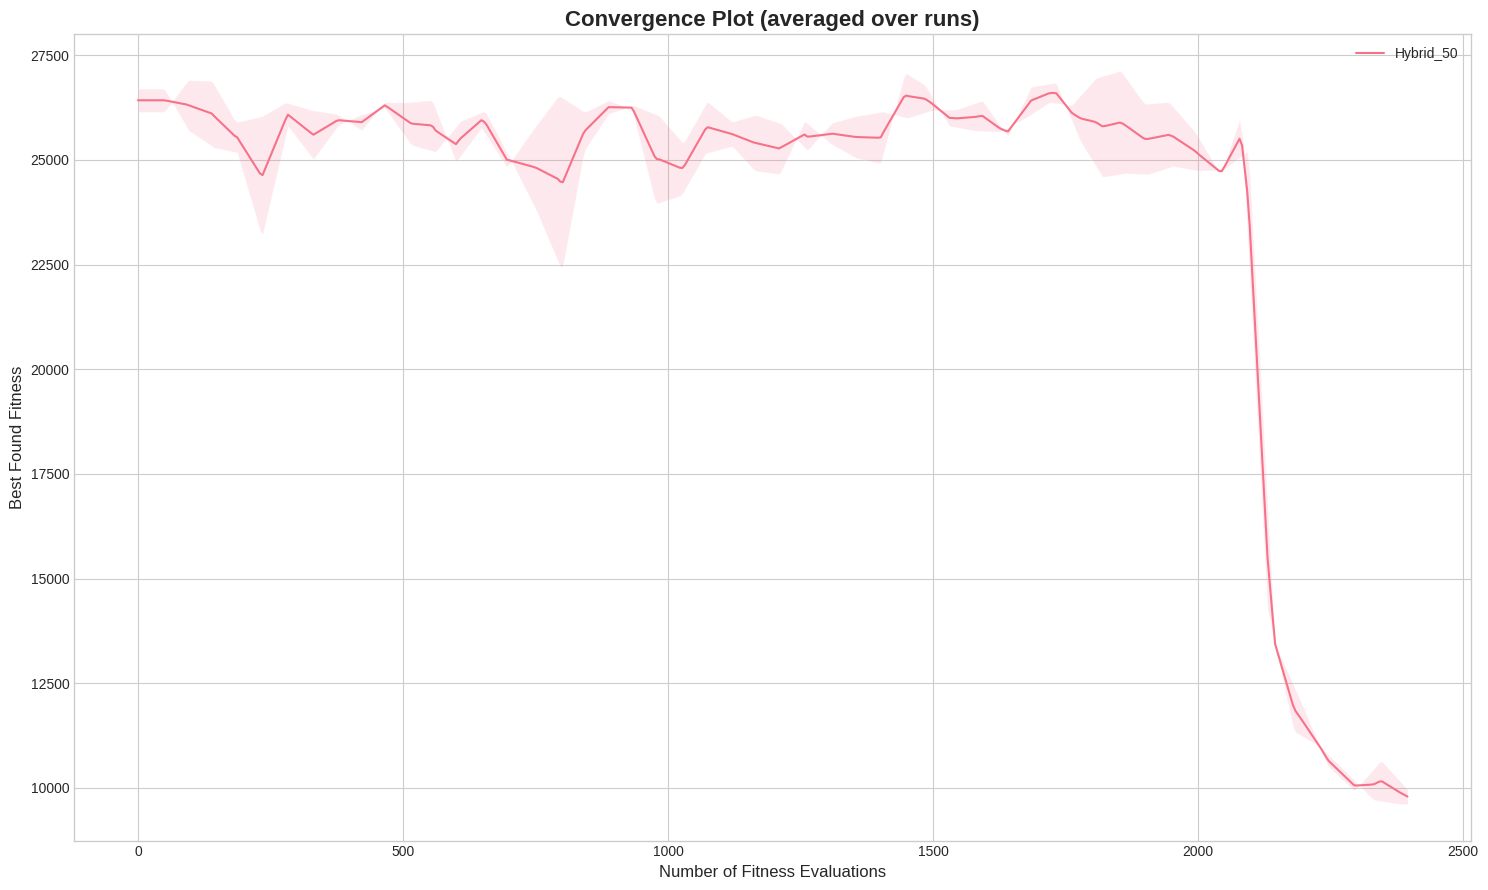

In [9]:
from gpt_plot import plot_ea_convergence

plot_ea_convergence(all_logs=all_logs)





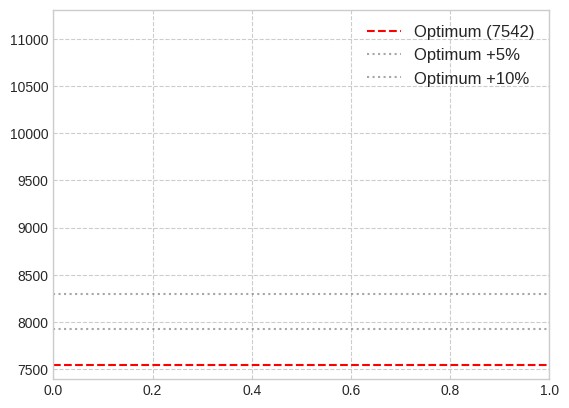

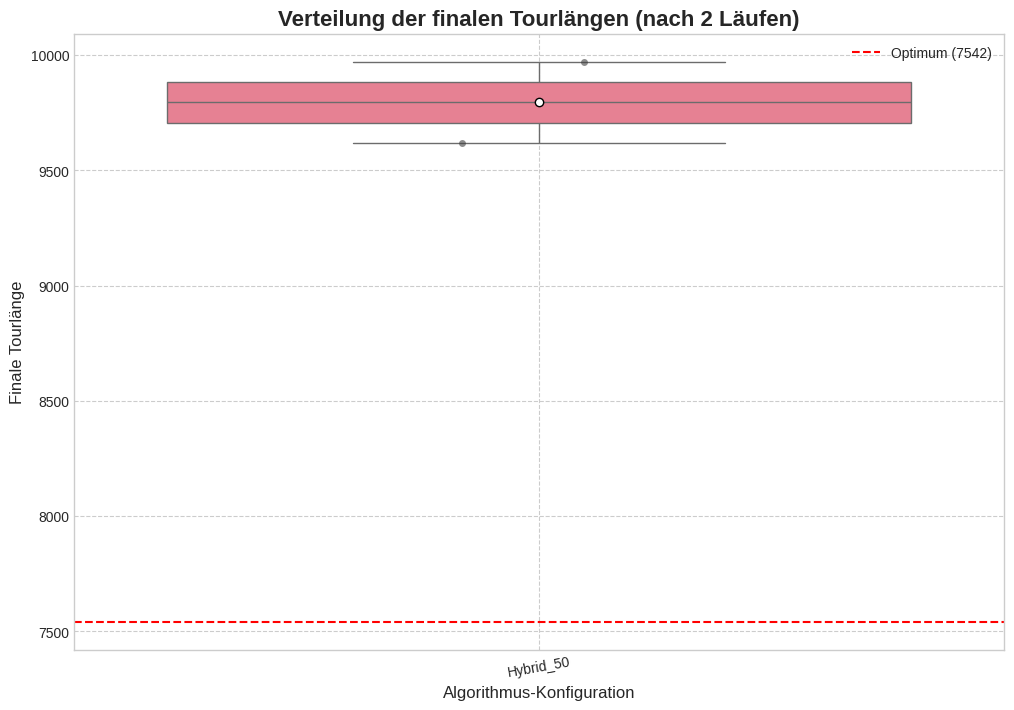

In [10]:

# Optimum und Prozentlinien
plt.axhline(OPTIMUM_TOUR, color='red', linestyle='--', label=f'Optimum ({OPTIMUM_TOUR})')
plt.axhline(OPTIMUM_TOUR * 1.05, color='gray', linestyle=':', alpha=0.7, label='Optimum +5%')
plt.axhline(OPTIMUM_TOUR * 1.10, color='gray', linestyle=':', alpha=0.7, label='Optimum +10%')

plt.legend(fontsize=12)
plt.ylim(bottom=OPTIMUM_TOUR * 0.98, top=OPTIMUM_TOUR*1.5)
plt.grid(True, which='both', linestyle='--')
plt.show()

# --- 7.2 BOX-PLOTS DER FINALEN ERGEBNISSE ---
plt.figure(figsize=(12, 8))
plt.title(f'Verteilung der finalen Tourlängen (nach {NUM_RUNS} Läufen)', fontsize=16, weight='bold')
df_results = pd.DataFrame(all_results)
sns.boxplot(data=df_results, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
sns.stripplot(data=df_results, color=".25", size=5, alpha=0.6)
plt.ylabel('Finale Tourlänge', fontsize=12)
plt.xlabel('Algorithmus-Konfiguration', fontsize=12)
plt.axhline(OPTIMUM_TOUR, color='red', linestyle='--', label=f'Optimum ({OPTIMUM_TOUR})')
plt.legend()
plt.xticks(rotation=10)
plt.grid(True, which='both', linestyle='--')
plt.show()

In [11]:

# --- 7.3 STATISTISCHE TESTS ---
print("\n--- Statistische Auswertung ---")

def compare_algorithms(name1:str, name2:str):
    results1 = all_results.get(name1)
    results2 = all_results.get(name2)

    if not results1 or not results2:
        print(f"Konnte Ergebnisse für '{name1}' oder '{name2}' nicht finden.")
        return

    print(f"\nVergleich: {name1} vs. {name2}")

    # Shapiro-Wilk-Test für Normalität
    p_shapiro1 = shapiro(results1).pvalue
    p_shapiro2 = shapiro(results2).pvalue
    print(f"Shapiro-Wilk p-Wert für {name1}: {p_shapiro1:.4f}")
    print(f"Shapiro-Wilk p-Wert für {name2}: {p_shapiro2:.4f}")

    if p_shapiro1 <= 0.05 or p_shapiro2 <= 0.05:
        print("Mindestens eine Verteilung ist nicht normalverteilt. Wir verwenden den Mann-Whitney-U-Test.")
        # Mann-Whitney-U-Test
        u_stat, p_value = mannwhitneyu(results1, results2, alternative='two-sided')
        print(f"Mann-Whitney-U-Test p-Wert: {p_value:.4f}")
        if p_value < 0.05:
            winner = name1 if np.mean(results1) < np.mean(results2) else name2
            print(f"-> Der Unterschied ist statistisch signifikant. {winner} ist besser.")
        else:
            print("-> Der Unterschied ist nicht statistisch signifikant.")
    else:
        print("Daten scheinen normalverteilt zu sein. (t-Test wäre anwendbar, wir bleiben aber konsistent beim U-Test)")

# keys of all_result dictionary are like follows and are pairwise compared like below
# key = f'{name}_{pop_size}'

# compare_algorithms('EA_100', 'Hybrid_100')
# compare_algorithms('EA_50', 'Hybrid_50')
# compare_algorithms('Hybrid_50', 'Hybrid_100')

for pop_size in POP_SIZES:
    compare_algorithms(f'EA_{pop_size}', f'Hybrid_{pop_size}')



--- Statistische Auswertung ---
Konnte Ergebnisse für 'EA_50' oder 'Hybrid_50' nicht finden.



Beste gefundene Tour stammt von 'Hybrid_50' mit einer Länge von 9619.12


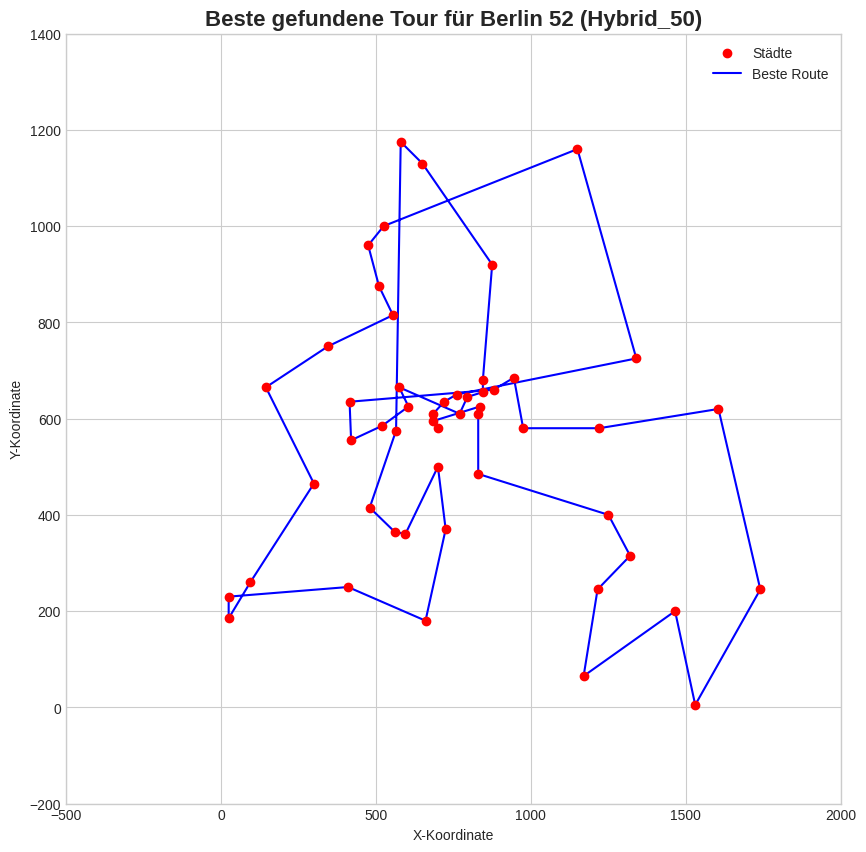

In [12]:
plot_city_tour(all_results,best_tours,coords,data_type)

In [13]:
'for each func call a key, each key has a list of N_Runs length, for each RUN best route'
all_results['Hybrid_20']

KeyError: 'Hybrid_20'

In [32]:
'for each func call a key, each key has a list of N_Runs length, for each RUN a matrix df of (N_GENERATIONS +1) row '
'also 4 columns for matrix called Generation, Gesamte_Fitness_Evaluations, Beste_Fitness_Generation, Avg_Fitness_Generation '
moodle = all_logs['Hybrid_20']
kudle = moodle[0] # first RUN
kudle

,Generation,Gesamte_Fitness_Evaluations,Beste_Fitness_Generation,Avg_Fitness_Generation
0,0,20,25643.091432,29228.693090
1,1,39,25559.440743,29498.067015
2,2,57,26754.270769,30134.793524
3,3,77,27435.636893,31209.985824
4,4,93,29086.763985,31147.306563
...,...,...,...,...
96,96,1806,11111.370705,22880.906526
97,97,1826,11825.385676,22945.729904
98,98,1846,12280.014206,22072.818261
99,99,1866,11458.422000,21700.943215


In [33]:
kudle.tail()

,Generation,Gesamte_Fitness_Evaluations,Beste_Fitness_Generation,Avg_Fitness_Generation
96,96,1806,11111.370705,22880.906526
97,97,1826,11825.385676,22945.729904
98,98,1846,12280.014206,22072.818261
99,99,1866,11458.422000,21700.943215
100,100,1886,13138.027534,20846.369292


In [40]:
'for each func call a key, on each key, a list of city indices that correspond to best tour'
k = list(best_tours.keys())[0]
len(best_tours[k])

52

## Problem:
seems like there is best overall fitness and then there is calculate_tour_length(best_tours['Hybrid_20]) which does not return the same value, which one is supposed to be shortest length?  


In [36]:


best_overall_fitness = float('inf')
best_overall_tour = None
best_overall_key = ""


for key, fitness_list in all_results.items():
    if not fitness_list: continue
    min_fitness_in_key = min(fitness_list)
    if min_fitness_in_key < best_overall_fitness:
        best_overall_fitness = min_fitness_in_key
        best_overall_tour = best_tours[key]
        best_overall_key = key

print(f"\nBeste gefundene Tour stammt von '{best_overall_key}' mit einer Länge von {best_overall_fitness:.2f}")


# Tour plotten
if best_overall_tour:
    # Schließe die Tour für die Visualisierung
    plot_tour = best_overall_tour + [best_overall_tour[0]]
    tour_coords = coords[plot_tour]




Beste gefundene Tour stammt von 'Hybrid_20' mit einer Länge von 10629.26


[27,
 21,
 30,
 17,
 2,
 18,
 44,
 39,
 36,
 47,
 26,
 12,
 51,
 13,
 46,
 25,
 45,
 15,
 49,
 19,
 22,
 29,
 28,
 43,
 33,
 34,
 38,
 35,
 48,
 31,
 40,
 7,
 9,
 8,
 16,
 6,
 1,
 41,
 20,
 0,
 37,
 23,
 24,
 11,
 10,
 50,
 32,
 42,
 14,
 4,
 5,
 3]

In [54]:
k = list(best_tours.keys())[0]
b_tour = best_tours[k] 


old_tour_length = calculate_tour_length(tour=b_tour,dist_matrix=dist_matrix)
old_tour_length

np.float64(11046.695347196306)

np.float64(11046.695347196306)

'Hybrid_20'